## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

import torch
from torch import nn

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [63]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

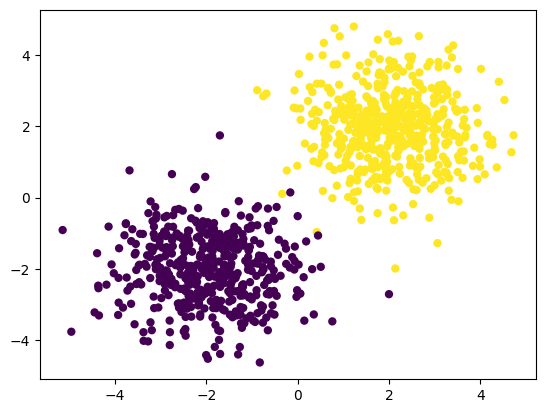

In [127]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [128]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [16]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [14]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

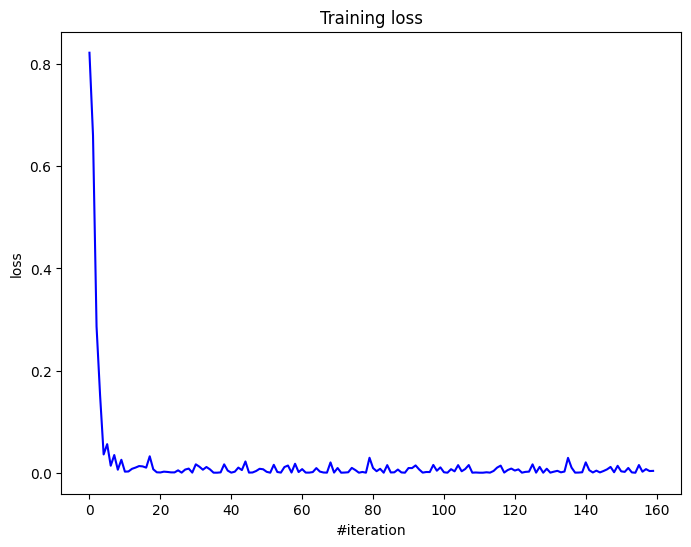

Current loss: 0.003622


In [131]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [5]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()


One-hot encode the labels first.

In [210]:
X_train.shape, y_train.shape

((50000, 28, 28), (50000,))

In [7]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
y_train = np.array(enc.fit_transform(y_train.reshape(-1, 1)).todense()) 
y_val = np.array(enc.transform(y_val.reshape(-1, 1)).todense()) 
y_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense()) 

image_size = 28**2
X_train = X_train.reshape(X_train.shape[0], image_size)
X_val = X_val.reshape(X_val.shape[0], image_size)
X_test = X_test.reshape(X_test.shape[0], image_size)

In [212]:
X_train.shape, y_train.shape

((50000, 784), (50000, 10))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [136]:
# Your code goes here. ################################################

def train(net, optimizer):
    history_loss = []
    for _ in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            optimizer(net.getParameters(),
                        net.getGradParameters(),
                        optimizer_config,
                        optimizer_state)
            history_loss.append(loss) 
    return history_loss

## ReLU

In [137]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_relu = train(net, sgd_momentum)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax

CPU times: total: 59.2 s
Wall time: 43 s


## ELU

In [91]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ELU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_elu = train(net, sgd_momentum)

Linear 784 -> 128
ELU
Linear 128 -> 10
LogSoftMax

CPU times: total: 53.6 s
Wall time: 42.4 s


## LeakyReLU

In [92]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(LeakyReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_relu_l = train(net, sgd_momentum)

Linear 784 -> 128
LeakyReLU
Linear 128 -> 10
LogSoftMax

CPU times: total: 54.9 s
Wall time: 42.2 s


## SoftPlus

In [93]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(SoftPlus())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_soft_plus = train(net, sgd_momentum)

Linear 784 -> 128
SoftPlus
Linear 128 -> 10
LogSoftMax

CPU times: total: 1min 1s
Wall time: 43.1 s


## ReLU + BatchNormalization

In [94]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_relu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ReLU
Linear 128 -> 10
LogSoftMax

CPU times: total: 55.7 s
Wall time: 43.3 s


## ELU + BatchNorm

In [95]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ELU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_elu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
ELU
Linear 128 -> 10
LogSoftMax

CPU times: total: 58.1 s
Wall time: 43.3 s


## LeakyReLU + BatchNorm

In [96]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(LeakyReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_l_Relu = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 128 -> 10
LogSoftMax

CPU times: total: 59.2 s
Wall time: 43 s


## SoftPlus + BatchNorm

In [97]:
%%time
batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(SoftPlus())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

optimizer_config = {'learning_rate' : 0.1, 'momentum': 0.95}
optimizer_state = {}
loss_history_batchn_softplus = train(net, sgd_momentum)

Linear 784 -> 128
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 128 -> 10
LogSoftMax

CPU times: total: 55.8 s
Wall time: 43.4 s


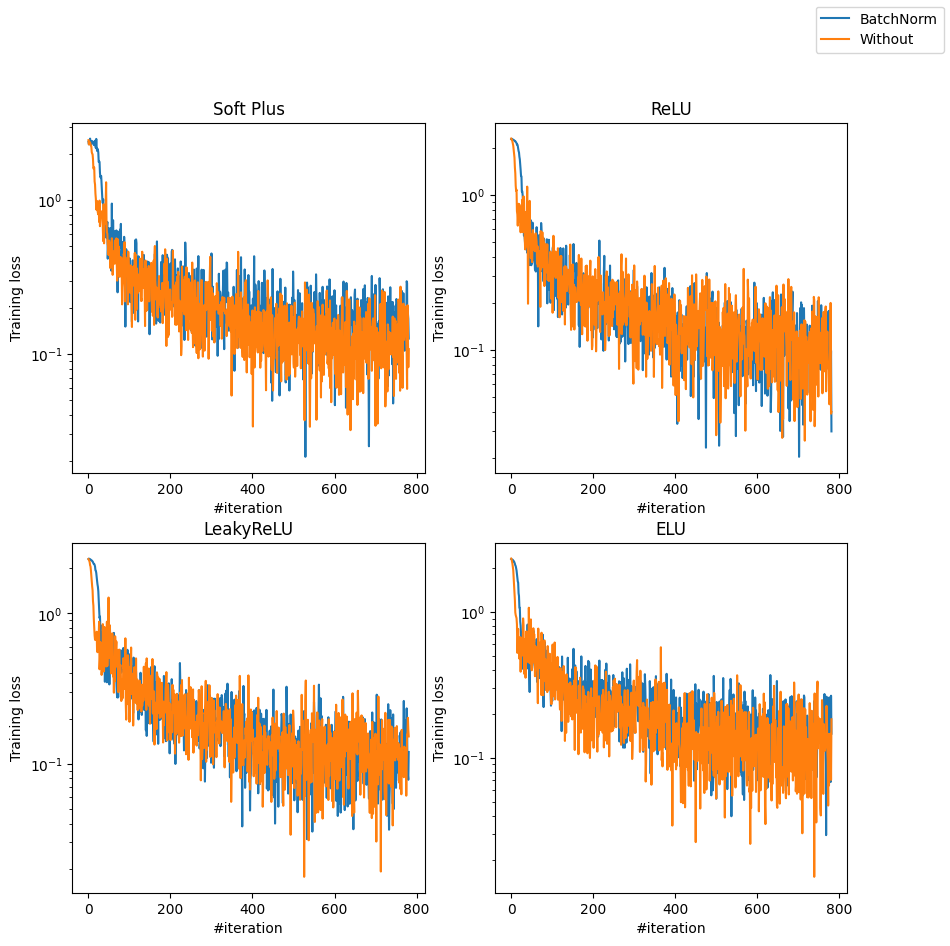

In [98]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].semilogy(loss_history_batchn_softplus, label='BatchNorm')
axs[0, 0].semilogy(loss_history_soft_plus, label='Without')
axs[0, 0].set_title('Soft Plus')

axs[0, 1].semilogy(loss_history_batchn_relu)
axs[0, 1].semilogy(loss_history_relu)
axs[0, 1].set_title('ReLU')

axs[1, 0].semilogy(loss_history_batchn_l_Relu)
axs[1, 0].semilogy(loss_history_relu_l)
axs[1, 0].set_title('LeakyReLU')

axs[1, 1].semilogy(loss_history_batchn_elu)
axs[1, 1].semilogy(loss_history_elu)
axs[1, 1].set_title('ELU')

for ax in axs.flat:
    ax.set(xlabel='#iteration', ylabel='Training loss')
fig.legend();

## Adam Oprimizer

In [99]:
%%time

batch_size = 128
output_size = 10
n_epoch = 2

net = Sequential()
net.add(Linear(image_size, 128))
net.add(ReLU())
net.add(Linear(128, output_size))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)
optimizer_config = {'learning_rate' : 0.1, 'beta1': 0.97, 'beta2': 0.98, 'epsilon': 1e-2}
optimizer_state = {}
loss_history_adam_relu = train(net, adam_optimizer)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax

CPU times: total: 54.5 s
Wall time: 42.8 s


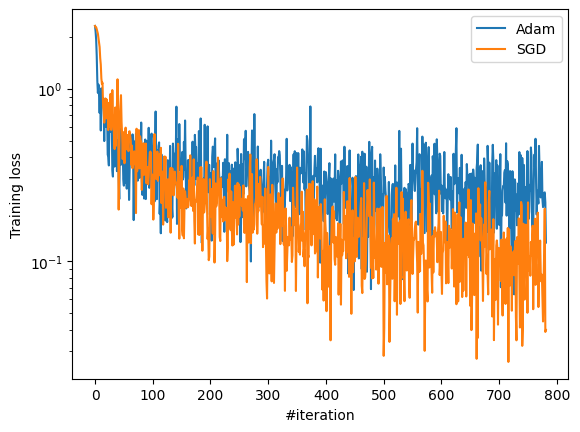

In [100]:
plt.semilogy(loss_history_adam_relu, label='Adam')
plt.semilogy(loss_history_relu, label='SGD')
plt.xlabel('#iteration')
plt.ylabel('Training loss')
plt.legend();

In [101]:
loss_history_adam_relu[-1]

0.12802255195569123

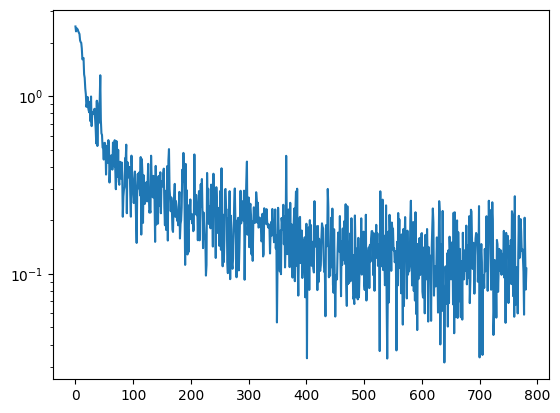

In [102]:
plt.semilogy(loss_history_soft_plus, label='Soft Plus')

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Write your personal opinion on the activation functions, think about computation times too**

Если рассматривать такие функции активации, как ReLU, то они серьезно помогают в улучшении скорости обучения нейросети, в том числе снижают нагрузку на вычислительные мощности, тк сами легко вычисляются.
Но всегда необходимо искать некоторые компромиссы между простотой функции, затратами на вычисление и теми недостатками, которыми обладает тот или иной тип функции активации.

**Does BatchNormalization help?**

BatchNormalization также серьезно помогает в обучении нейронных сетей. BatchNormalization нормализует входные данные слоев, уменьшая внутренний сдвиг центрированием и обеспечивает более высокую скорость обучения и более быструю сходимость решения. Собственно это приводит к ускорению процесса обучения сети, но необходимо учитывать, что пакетная нормализация хорошо работает на средних и больших батчах, при этом на маленьких размерах вклад BatchNormalization будет минимален.
Как и в случае функций активации, необходимо учитывать некоторые компромиссы, тк при всем своем удобстве пакетная нормализация также требует вычислительных накладных ресурсов в процесс обучения.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [3]:
import numpy as np

import torch

from matplotlib import pyplot as plt

In [52]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

enc = OneHotEncoder()
y_train = np.array(enc.fit_transform(y_train.reshape(-1, 1)).todense())
y_val = np.array(enc.transform(y_val.reshape(-1, 1)).todense())
y_test = np.array(enc.transform(y_test.reshape(-1, 1)).todense())

image_size = 28**2
X_train = X_train.reshape(X_train.shape[0], image_size)
X_val = X_val.reshape(X_val.shape[0], image_size)
X_test = X_test.reshape(X_test.shape[0], image_size)

Реализуем нашу cool model и посмотрим на ее точность и значение функции потерь:

In [53]:
# Your code goes here. ################################################
model = Sequential()
model.add(Flatten())
model.add(Linear(784, 256))
model.add(ReLU())
model.add(Dropout())
model.add(Linear(256, 128))
model.add(ReLU())
model.add(Dropout())
model.add(BatchNormalization(alpha=0.1))
model.add(Linear(128, 10))
model.add(LogSoftMax())


In [54]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [55]:
batch_size = 512
output_size = 10
n_epoch = 10

optimizer = adam_optimizer
optimizer_config = {
    'learning_rate' : 0.001,
    'beta1': 0.9,
    'beta2': 0.99,
    'epsilon':1e-8
}
optimizer_state = {}

criterion = ClassNLLCriterion()
model

Flatten
Linear 784 -> 256
ReLU
Dropout
Linear 256 -> 128
ReLU
Dropout
BatchNormalization
Linear 128 -> 10
LogSoftMax

In [56]:
train_loss = []
test_loss = []

for _ in range(n_epoch):
    model.train()
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        model.zeroGradParameters()
        predictions = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        model.backward(x_batch, dp)
        optimizer(model.getParameters(),
                  model.getGradParameters(),
                  optimizer_config,
                  optimizer_state)
        train_loss.append(loss)

    model.evaluate()
    predictions = model.forward(X_val)
    test_loss_epoch = criterion.forward(predictions, y_val)
    test_loss.append(test_loss_epoch)


In [57]:
print('Train Loss:', train_loss[-1])
print('Test Loss:', test_loss[-1])

Train Loss: 0.09834951303096615
Test Loss: 0.07416114516500573


Как видим, значения функции потерь получились вполне достойными.
Построим графики

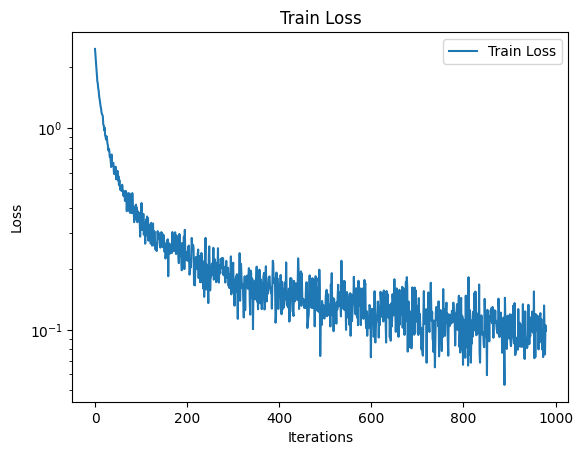

In [58]:
plt.plot(train_loss, label='Train Loss')
plt.title('Train Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

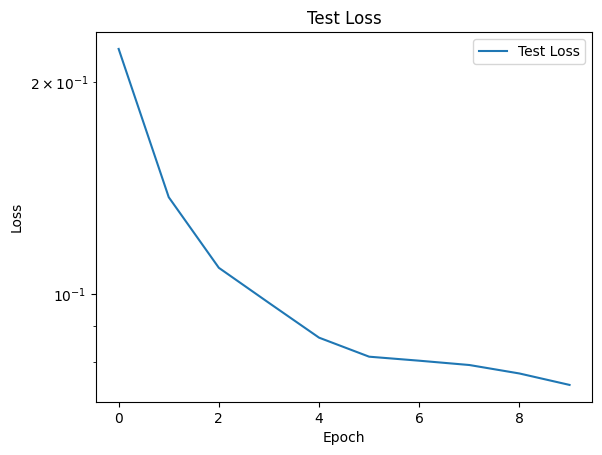

In [59]:
plt.plot(test_loss, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

Print here your accuracy on test set. It should be around 90%.

Посчитаем точность модели:

In [60]:
from sklearn.metrics import accuracy_score

X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

model.evaluate()
probas = model.forward(X_test)
predictions = probas.argmax(axis=-1)
print(f'Accuracy : {accuracy_score(predictions, y_test)}')

Accuracy : 0.9778


Точность модели получилась более 95%, что очень не плохо. Теперь попробуем сравнить решение с реализацией PyTorch

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [66]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [68]:
# Your beautiful code here.
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=-1)
)

n_epoch = 20
batch_size=512
optimizer_state = {}

optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.NLLLoss()
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=128, out_features=10, bias=True)
  (9): LogSoftmax(dim=-1)
)

In [69]:
train_loss_history = []
val_loss_history = []

train_loss = []
test_loss = []

for _ in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        model.train()
        predictions = model.forward(torch.FloatTensor(x_batch).unsqueeze(1).to(device))
        loss = criterion(predictions, torch.LongTensor(y_batch).to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())

        model.eval()
        with torch.no_grad():
            predictions = model.forward(torch.FloatTensor(X_val).unsqueeze(1).to(device))
            test_loss_epoch = criterion(predictions, torch.LongTensor(y_val).to(device))
            test_loss.append(test_loss_epoch.item())
    scheduler.step()

In [70]:
print('Train Loss:', train_loss[-1])
print('Test Loss:', test_loss[-1])

Train Loss: 0.06587771326303482
Test Loss: 0.06664739549160004


Значение функции потерь впечатляют, расходимости на трейне и тесте практически нет.
Построим графики и посмотрим далее на значение точности.

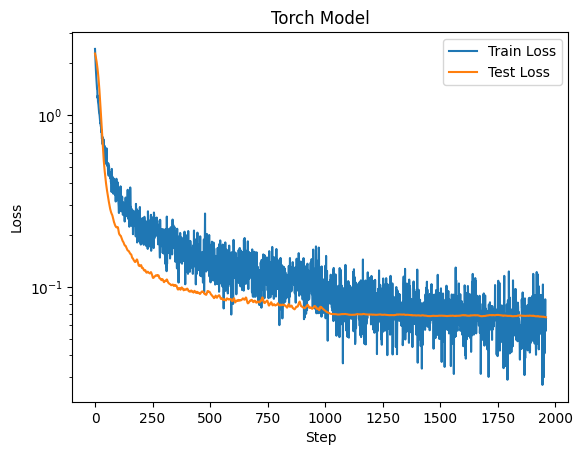

In [71]:
plt.plot(np.array(train_loss), label='Train Loss')
plt.plot(np.array(test_loss), label='Test Loss')
plt.title('Torch Model')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [72]:
model.eval()
with torch.no_grad():
    probas = model.forward(torch.FloatTensor(X_test).unsqueeze(1).to(device))
    predictions = probas.argmax(dim=-1).cpu().numpy()

print('Accuracy : ', accuracy_score(predictions, y_test))

Accuracy :  0.9805


В реализации и нашей модели и с PyTorch использовал функции активации RELU, Dropoup и BatchNormalization.
Точность модели, реализованный с помощью пакета PyTorch показывает лучшие результаты по точности и функции потерь:

Accuracy Custom: 0.9778
Accuracy PyTorch:  0.9805

Но реализованная наша модель незначительно отстает от показателей PyTorch, что очень хорошо, но имеет явный минус - это более длительное время обучения при меньшем уровне эпох.